# ACCESSING SPOTIFY


## IMPORT

In [2]:
import spotipy
import spotipy.util as util
from spotipy.oauth2 import SpotifyClientCredentials
import json
import pandas as pd
import requests
import re
import glob
import matplotlib.pyplot as plt
%matplotlib inline 
#visualization option

## AUTHENTIFICATION

In [8]:
'''CREATE SPOTFIY CREDENTIAL FILE
cred = {}
cred['USER'] = ''
cred['CLIENT_ID'] = ''
cred['CLIENT_SECRET'] = ''
cred['ACCESS_TOKEN'] = ''

with open('spotify_credentials.json', 'w') as outfile:
    json.dump(cred, outfile)
'''

In [3]:
#call and read your personal credential file
with open ('spotify_credentials.json', 'r') as infile:
    credentials=json.loads(infile.read())

### Create and refresh token
run this to  refresh the token. Token runs out every 3600 seconds.

In [42]:
token = SpotifyClientCredentials(client_id=credentials['CLIENT_ID'], client_secret=credentials['CLIENT_SECRET'])
cache_token = token.get_access_token()
sp = spotipy.Spotify(cache_token)
print(cache_token)

BQA3nToIVoAk3DxVcg6xBMadUfwPUnz35D2eYoPX7aG0yuvyQfdwyGnwjt1Au16RTO7iQx9yjJ5jSx36hFI


<ipython-input-42-10afbe187d0a>:2: DeprecationWarning: You're using 'as_dict = True'.get_access_token will return the token string directly in future versions. Please adjust your code accordingly, or use get_cached_token instead.
  cache_token = token.get_access_token()


# DOWNLOAD CHARTS TO FOLDER
DEFINING CSVs of which charts to download by Date, Region and if viral charts or top200

In [47]:
# VIRAL CHART sample URL https://spotifycharts.com/viral/us/daily/2020-03-13/download
# thats how i want filename to be safed regional-us-weekly-2020-03-13--2020-03-20.csv

date_charts='2019-04-15' #From which date do you want to pull spotify charts? format YYYY-MM-DD
country_charts=['br','it','us','sg','za'] #enter list of country codes
what_charts='regional' # enter as string 'viral' for viral top 50 or 'regional' for top 200

In [29]:
#HINT: LIST OF COUNTRY CHARTS
print(sp.country_codes)

['AD', 'AR', 'AU', 'AT', 'BE', 'BO', 'BR', 'BG', 'CA', 'CL', 'CO', 'CR', 'CY', 'CZ', 'DK', 'DO', 'EC', 'SV', 'EE', 'FI', 'FR', 'DE', 'GR', 'GT', 'HN', 'HK', 'HU', 'IS', 'ID', 'IE', 'IT', 'JP', 'LV', 'LI', 'LT', 'LU', 'MY', 'MT', 'MX', 'MC', 'NL', 'NZ', 'NI', 'NO', 'PA', 'PY', 'PE', 'PH', 'PL', 'PT', 'SG', 'ES', 'SK', 'SE', 'CH', 'TW', 'TR', 'GB', 'US', 'UY']


In [ ]:
#DOWNLOAD LOOP
for country in country_charts:
    url= f'https://spotifycharts.com/{what_charts}/{country}/daily/{date_charts}/download'
    print(url)
    r = requests.get(url, allow_redirects=True)
    open(f'spotify_{what_charts}/{date_charts}-{country}-{what_charts}.csv', 'wb').write(r.content)

In [ ]:
'''#DOWNLOAD SINGLE CSV BY SPECIFIC URL

url = 'https://spotifycharts.com/viral/us/daily/2020-03-13/download'
r = requests.get(url, allow_redirects=True)

open('spotify_viral/regional-viral-us-daily--2020-03-13.csv', 'wb').write(r.content)'''

# MULTIPLE CSV HANDLING
1. turns CSVs into data frame
2. extracts date, id, and country code from filename
3. work around spotify request limit

In [8]:
###multiple CSV
def multi_csv_handling(list_csvs):
    lst = []
    for filename in list_csvs:
        df = pd.read_csv(filename, index_col=None, header=1) 
        df = df.head() # set number auf rows you want to include from each imported csv
        df['id']= re.findall(r'\d\w+',str(list(df['URL']))) #extract ID from URL
        date=re.search(r'\d\d\d\d-\d\d-\d\d', filename).group()
        df['date']= date
        df['date']=pd.to_datetime(df.date, format="%Y-%m-%d")
        country=re.search(r'-[a-z][a-z]-', filename).group()
        df['country']= str(country)
        song_features=sp.audio_features(tracks=list(df['id']))##calling spotify API for features
        df_features = pd.json_normalize(song_features)
        df=pd.merge(df, df_features, on='id') # merging df and df_feature on 'id'
        lst.append(df) #turn df into list
        
    df = pd.concat(lst, axis=0, ignore_index=True)
    return df

# CALL FUNCTION ON FOLDER w/ CSVs

In [6]:
# ADRESS FOLDER WITH CSVs + CALL FUNCTION
path = r'spotify_regional/' # path for folder
list_csvs = glob.glob(path + "/*.csv")

In [9]:
df=multi_csv_handling(list_csvs)
df

,Position,Track Name,Artist,Streams,URL,id,date,country,danceability,energy,...,instrumentalness,liveness,valence,tempo,type,uri,track_href,analysis_url,duration_ms,time_signature
0,1,WAP (feat. Megan Thee Stallion),Cardi B,15520,https://open.spotify.com/track/4Oun2ylbjFKMPTi...,4Oun2ylbjFKMPTiaSbbCih,2020-09-15,-za-,0.935,0.454,...,0.000000,0.0824,0.357,133.073,audio_features,spotify:track:4Oun2ylbjFKMPTiaSbbCih,https://api.spotify.com/v1/tracks/4Oun2ylbjFKM...,https://api.spotify.com/v1/audio-analysis/4Oun...,187541,4
1,2,Mood (feat. iann dior),24kGoldn,13500,https://open.spotify.com/track/3tjFYV6RSFtuktY...,3tjFYV6RSFtuktYl3ZtYcq,2020-09-15,-za-,0.700,0.722,...,0.000000,0.2720,0.756,90.989,audio_features,spotify:track:3tjFYV6RSFtuktYl3ZtYcq,https://api.spotify.com/v1/tracks/3tjFYV6RSFtu...,https://api.spotify.com/v1/audio-analysis/3tjF...,140526,4
2,3,Laugh Now Cry Later (feat. Lil Durk),Drake,11555,https://open.spotify.com/track/2SAqBLGA283SUiw...,2SAqBLGA283SUiwJ3xOUVI,2020-09-15,-za-,0.761,0.518,...,0.000035,0.1070,0.522,133.976,audio_features,spotify:track:2SAqBLGA283SUiwJ3xOUVI,https://api.spotify.com/v1/tracks/2SAqBLGA283S...,https://api.spotify.com/v1/audio-analysis/2SAq...,261493,4
3,4,ROCKSTAR (feat. Roddy Ricch),DaBaby,9901,https://open.spotify.com/track/7ytR5pFWmSjzHJI...,7ytR5pFWmSjzHJIeQkgog4,2020-09-15,-za-,0.746,0.690,...,0.000000,0.1010,0.497,89.977,audio_features,spotify:track:7ytR5pFWmSjzHJIeQkgog4,https://api.spotify.com/v1/tracks/7ytR5pFWmSjz...,https://api.spotify.com/v1/audio-analysis/7ytR...,181733,4
4,5,Xola Moya Wam',Nomcebo Zikode,9789,https://open.spotify.com/track/0CLyxycXWr4PP7P...,0CLyxycXWr4PP7PgeGRn8u,2020-09-15,-za-,0.807,0.703,...,0.021500,0.0491,0.617,113.992,audio_features,spotify:track:0CLyxycXWr4PP7PgeGRn8u,https://api.spotify.com/v1/tracks/0CLyxycXWr4P...,https://api.spotify.com/v1/audio-analysis/0CLy...,304211,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
445,1,WANNABE,ITZY,46449,https://open.spotify.com/track/6tCssnvTUREcper...,6tCssnvTUREcperDOUTqvA,2020-03-15,-sg-,0.809,0.911,...,0.000179,0.1810,0.640,122.035,audio_features,spotify:track:6tCssnvTUREcperDOUTqvA,https://api.spotify.com/v1/tracks/6tCssnvTUREc...,https://api.spotify.com/v1/audio-analysis/6tCs...,191242,4
446,2,Intentions (feat. Quavo),Justin Bieber,42044,https://open.spotify.com/track/4umIPjkehX1r7uh...,4umIPjkehX1r7uhmGvXiSV,2020-03-15,-sg-,0.806,0.546,...,0.000000,0.1020,0.874,147.986,audio_features,spotify:track:4umIPjkehX1r7uhmGvXiSV,https://api.spotify.com/v1/tracks/4umIPjkehX1r...,https://api.spotify.com/v1/audio-analysis/4umI...,212867,4
447,3,Dance Monkey,Tones And I,38583,https://open.spotify.com/track/1rgnBhdG2JDFTbY...,1rgnBhdG2JDFTbYkYRZAku,2020-03-15,-sg-,0.825,0.593,...,0.000161,0.1700,0.540,98.078,audio_features,spotify:track:1rgnBhdG2JDFTbYkYRZAku,https://api.spotify.com/v1/tracks/1rgnBhdG2JDF...,https://api.spotify.com/v1/audio-analysis/1rgn...,209755,4
448,4,Don't Start Now,Dua Lipa,35269,https://open.spotify.com/track/6WrI0LAC5M1Rw2M...,6WrI0LAC5M1Rw2MnX2ZvEg,2020-03-15,-sg-,0.794,0.793,...,0.000000,0.0952,0.677,123.941,audio_features,spotify:track:6WrI0LAC5M1Rw2MnX2ZvEg,https://api.spotify.com/v1/tracks/6WrI0LAC5M1R...,https://api.spotify.com/v1/audio-analysis/6WrI...,183290,4


# EXPORT DATAFRAME AS CSV
CSV for further analysis

In [52]:
#EXPORT DATAFRAME TO CSV
df.to_csv('_all_spotify_data.csv', sep=',')

# ANALYSIS EXAMPLE

### Danceablity over time

In [71]:
italy_dance=df[df['country']=='-it-'].groupby(['date'])['Streams','danceability','energy','valence','tempo'].mean()
usa_dance=df[df['country']=='-us-'].groupby(['date'])['Streams','danceability','energy','valence','tempo'].mean()
singapur_dance=df[df['country']=='-sg-'].groupby(['date'])['Streams','danceability','energy','valence','tempo'].mean()
brazil_dance=df[df['country']=='-br-'].groupby(['date'])['Streams','danceability','energy','valence','tempo'].mean()

<ipython-input-71-13e69d42060f>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  italy_dance=df[df['country']=='-it-'].groupby(['date'])['Streams','danceability','energy','valence','tempo'].mean()
<ipython-input-71-13e69d42060f>:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  usa_dance=df[df['country']=='-us-'].groupby(['date'])['Streams','danceability','energy','valence','tempo'].mean()
<ipython-input-71-13e69d42060f>:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  singapur_dance=df[df['country']=='-sg-'].groupby(['date'])['Streams','danceability','energy','valence','tempo'].mean()
<ipython-input-71-13e69d42060f>:4: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  bra

# PLOTTING


<AxesSubplot:title={'center':'ITALY'}, xlabel='TIME', ylabel='DANCEABLITY'>

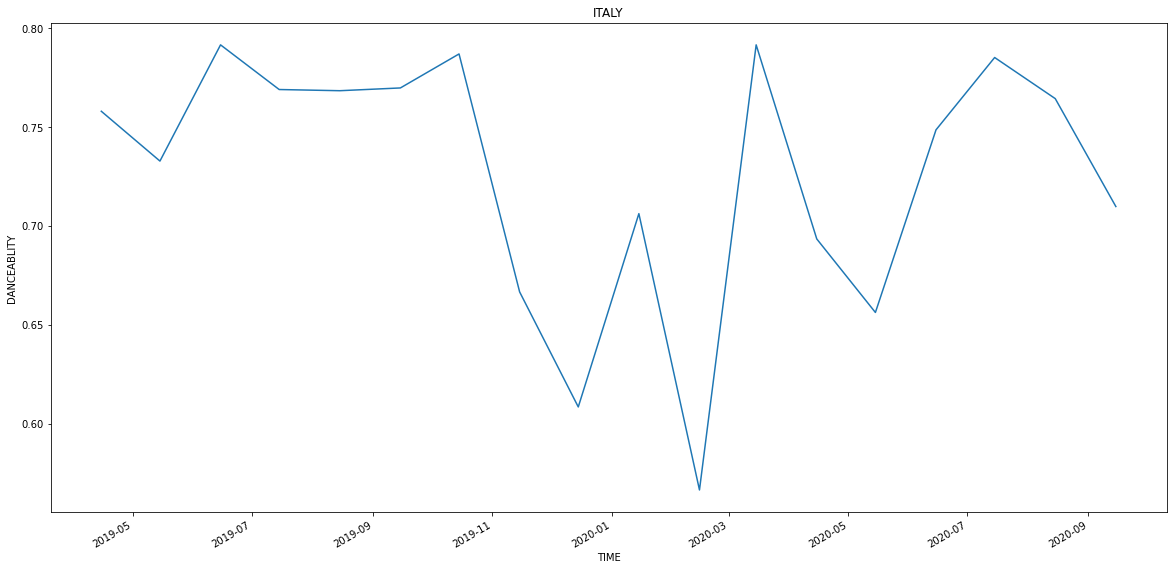

In [67]:
# ITALY DANCABLITY OVER TIME
italy_dance['danceability'].plot(x=italy_dance.index, y=italy_dance['danceability'], kind='line', figsize=(20,10),xlabel='TIME',ylabel='DANCEABLITY',title='ITALY')


<AxesSubplot:title={'center':'SINGAPUR'}, xlabel='TIME', ylabel='DANCEABLITY'>

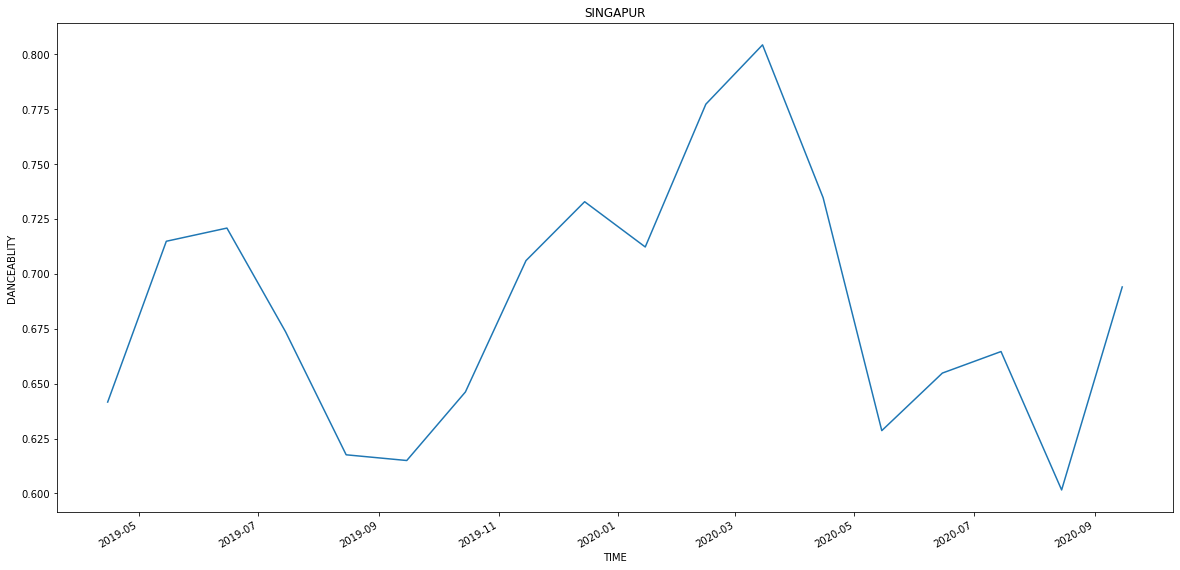

In [65]:
# SINGAPUR DANCEABLITY OVER TIME

singapur_dance['danceability'].plot(x=singapur_dance.index, y=singapur_dance['danceability'], kind='line', figsize=(20,10),xlabel='TIME',ylabel='DANCEABLITY',title='SINGAPUR')


<AxesSubplot:title={'center':'USA'}, xlabel='TIME', ylabel='DANCEABLITY'>

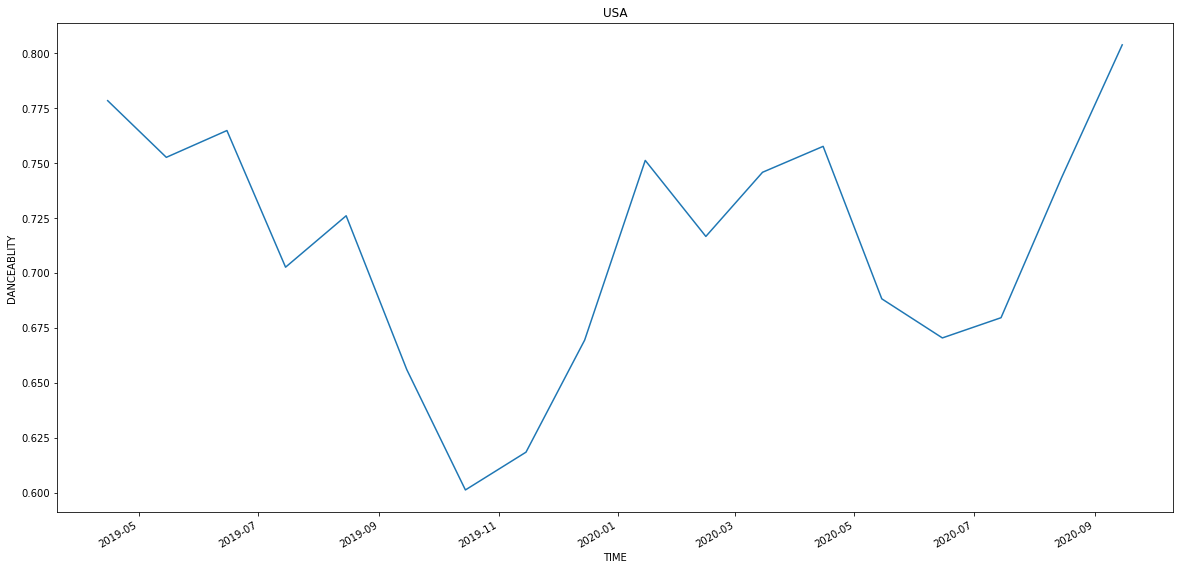

In [68]:
usa_dance['danceability'].plot(x=usa_dance.index, y=usa_dance['danceability'], kind='line', figsize=(20,10),xlabel='TIME',ylabel='DANCEABLITY',title='USA')


<AxesSubplot:title={'center':'BRAZIL'}, xlabel='TIME', ylabel='DANCEABLITY'>

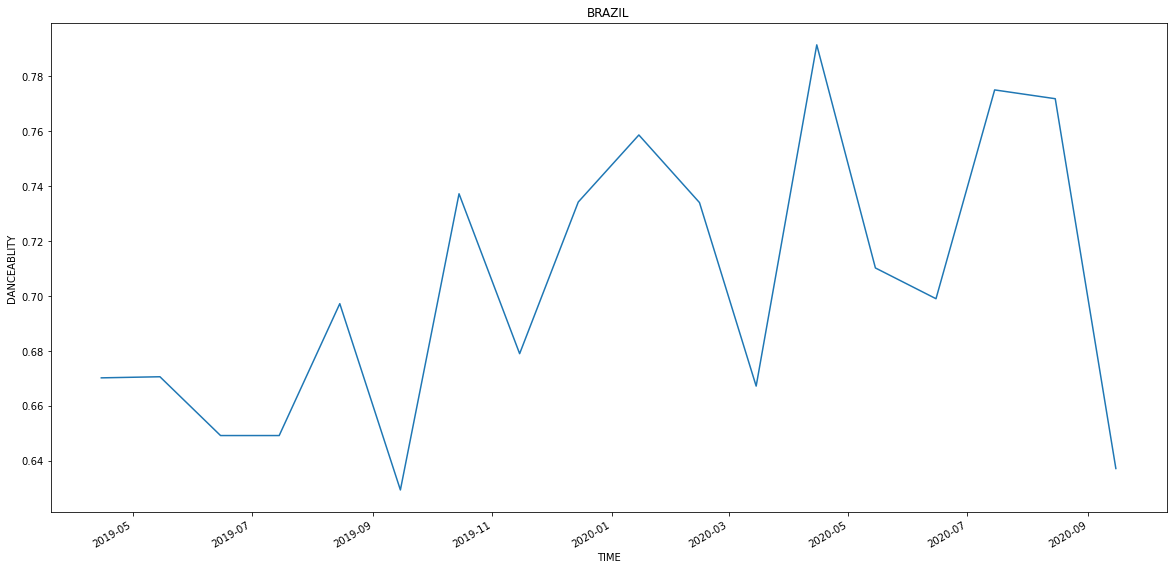

In [73]:
brazil_dance['danceability'].plot(x=brazil_dance.index, y=brazil_dance['danceability'], kind='line', figsize=(20,10),xlabel='TIME',ylabel='DANCEABLITY',title='BRAZIL')
